In [1]:
import sys
import gym
import pylab
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from tqdm import tqdm

Using TensorFlow backend.
/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Agent

In [2]:
class policy_gradient_agent:
    
    def __init__(self, state_size, action_size, hidden_layer_size=24, weights=None):
        self.state_size = state_size
        self.action_size = action_size
        
        self.learning_rate = 0.001
        self.discount_factor = 0.99
        
        self.hidden_layer_size = hidden_layer_size
        self.model = self.build_model()
        if weights != None:
            self.model.load_weights(weights)
        
    
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.hidden_layer_size, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(self.hidden_layer_size, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_uniform'))
        model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(self.learning_rate))
        return model
    
    def next_action(self, state):
        policy = self.model.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
            
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)
        return discounted_rewards
    
    def fit_one_episode(self, episode):
        episode_length = len(episode["states"])

        discounted_rewards = self.discount_rewards(episode["rewards"])

        update_inputs = np.zeros((episode_length, self.state_size))
        advantages = np.zeros((episode_length, self.action_size))

        for i in range(episode_length):
            update_inputs[i] = episode["states"][i]
            advantages[i][episode["actions"][i]] = discounted_rewards[i]

        self.model.fit(update_inputs, advantages, epochs=1, verbose=0)
    
    def play_one_episode(self, env):
        
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        
        states, actions, rewards = [], [], []

        while not done:
            
            action = agent.next_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            reward = reward if not done or score == 499 else -100

            # save the sample <s, a, r> to the memory
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            score += reward
            state = next_state
        episode = {"states" : states,
                   "actions" : actions,
                   "rewards" : rewards}
        return episode
    
    def learn(self, env, nb_episodes=1000):
        scores = []
        pbar = tqdm(range(nb_episodes))
        for i in pbar:
            episode = self.play_one_episode(env)
            self.fit_one_episode(episode)
            scores.append(len(episode["rewards"]))
            pbar.set_description("episode: %s, score: %s" % (i, scores[i]))
            
            if (i > 50) and (sum(scores[i-9 : i+1]) / 10 > 490):
                break
        return scores       

# Environement

In [3]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = policy_gradient_agent(state_size, action_size)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


# Training

episode: 983, score: 500:  20%|█▉        | 983/5000 [08:23<34:16,  1.95it/s]

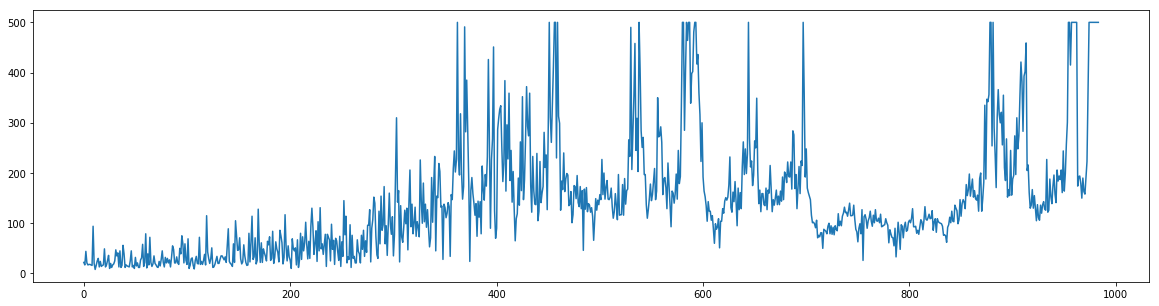

In [4]:
scores = agent.learn(env, 5000)
plt.figure(figsize=(20,5))
plt.plot(scores)

# Playing

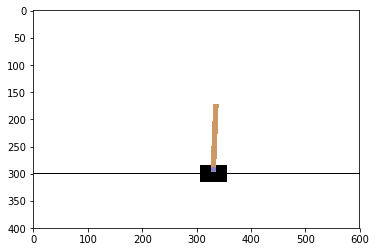

In [7]:
from distant_gym_render import distant_render
distant_render(env, agent, state_size)

# Save weights

In [6]:
agent.model.save_weights("./weights/policy_gradient_cartpole.h5")